In [2]:
#This Notebook presents a code to do a decompositon onto Alfven Slow and Fast modes
#Darryl Seligman version3 9/11/18
#Adapted from version of code by Jonathan Squire
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import *
import sys
sys.path.append('/Users/darrylseligman/Desktop/Flatiron/Phil/Initial_Magnetic_Simulations/PFH_python/pfh_python')
from get_particle_hsml_ngb import *
from grain_density_from_snapshot import *
from example_plotting_routine import *
def mode_decomp(Vx,Vy,Vz,beta):
    #Form grid of K
    n=Vx.shape[0]
    
    N=[n,n,n]
    L=[1.,1.,1.]
    if(n%2==0):
        b=np.arange(0,N[0]/2)
        bb = np.linspace(-N[0]/2.,-1,N[0]/2)
    else:
        print "hello"
        b=np.arange(0,N[0]/2)
        bb = np.linspace(-N[0]/2.,-1.5,N[0]/2)
        bb=np.append(bb,[.5])
    #Form k-space vectors for each dimension [0 1 2 3 ... N/2-1 -N/2 -N/2+1 ... -2 -1]*2*pi/L
    
    kx=  2*np.pi*1j/L[0]*np.concatenate((b,bb))
    ky=  2*np.pi*1j/L[1]*np.concatenate((b,bb))
    kz=  2*np.pi*1j/L[2]*np.concatenate((b,bb))
   
    #print kx.shape
    #xg=np.linspace(0.,1.,n)
    #yg=np.linspace(0.,1.,n)
    #zg=np.linspace(0.,1.,n)
    #x,y,az=np.meshgrid(xg,yg,zg,indexing='ij')
    #3D arrays of k-space grid
    KX,KY,KZ= np.meshgrid(kx,ky,kz)#,indexing='ij')
    #grid of |K|, kperp (B0 is in x direction) and k_hat
    Kmag = np.sqrt(abs(KX**2+KY**2+KZ**2))
    Kperp = np.sqrt(abs(KY**2+KX**2))
    #Kmag[0]=1.
    khx = KX/Kmag;
    khy = KY/Kmag;
    khz = KZ/Kmag;
    khx[np.isnan(khx)]=0.
    khy[np.isnan(khy)]=0.
    khz[np.isnan(khz)]=0.
    #k-Grid for binning the spectra
    kgrid = np.arange(0,max(ky.imag)+2.*np.pi/L[0],2.*np.pi/L[0])

    kgridG = (kgrid[0:kgrid.size-1] +  kgrid[1:kgrid.size])/2;   
    #Get B and V, take fourier transforms  
    fVx = fftn(Vx);
    fVy = fftn(Vy); 
    fVz = fftn(Vz);
    # % Alfvenic part -- part of B and u in k*b_hat direction                                                                                                                                                                      
    #% b_hat is x direction 
    kcbhz = 0;
    kcbhy = (khx);
    kcbhx =  - (khy);
    #Alfvenic part of V, (k*bh).V 
    alfV =  kcbhy*fVy + kcbhx*fVx;
    
    #% Now decompose compressive part into fast and slow                                                                                                                                                                          
    #% I think this is right, but never actually used this seriously  
    
    costh = abs(khz);
    sinth = np.sqrt(1.-costh**2);
    #costh[costh==0]=1.
    #sinth[sinth==0]=1.
    Kperp[Kperp==0]=1.;
    #for strong beta regime A33 - A34
    if(beta>1.e2):
        thx = -sinth*np.sign(KX);
        #thx = sinth*khx;
        Kperp[Kperp==0]=1.;
        thy = costh*(KY/Kperp);
        thz = costh*(KZ/Kperp);
        #% Slow wave part  
        slowV = -thx*fVx - thy*fVy - thz*fVz + costh*sinth/beta*(khx*fVx + khy*fVy + khz*fVz);
        #% Fast wave part  
        fastV = costh*sinth/beta*(thx*fVx + thy*fVy + thz*fVz) + khx*fVx + khy*fVy + khz*fVz;
    #General beta case A29 - A30
    elif(beta<1.e-2):
        alpha = beta/2.
        fz = np.sum(abs(khz*fVz))
        fxy = np.sum(abs((khy)*fVy + (khx)*fVx))
        fracz = fz/(fz+fxy)
        fracxy=fxy/(fz+fxy)
        
        
        
        #case of sin theta or cos theta =0
        if((fz==0.) or (fxy==0.)):
            slowV = ((khz*fVz)-costh*sinth*alpha*((khy)*fVy + (khx)*fVx))
            fastV = (costh*sinth*alpha*(khz*fVz)-((khy)*fVy + (khx)*fVx))
        else:   
            slowV = ((khz*fVz)-costh*sinth*alpha*((khy)*fVy + (khx)*fVx))/(fracz-costh*sinth*alpha*fracxy)
            fastV = (costh*sinth*alpha*(khz*fVz)-((khy)*fVy + (khx)*fVx))/(fracz*costh*sinth*alpha-fracz)
        

       
        
    else:
        print "hey!"
        alpha = beta/2.
        D = np.array(((1.+alpha)**2-4.*alpha*costh*costh),dtype=complex)
        #D=((1.+alpha)**2-4.*alpha*costh*costh)
        #normalize
        #SLOWVx = sinth*(1.+alpha-np.sqrt(D))
        #SLOWVy = sinth*(1.+alpha-np.sqrt(D))
        #SLOWVz = costh*(-1.+alpha-np.sqrt(D))
        
        SLOWVx = khx*(1.+alpha-np.sqrt(D))
        SLOWVy = khy*(1.+alpha-np.sqrt(D))
        SLOWVz = khz*(-1.+alpha-np.sqrt(D))
        
        slowVmag = np.sqrt(abs(SLOWVx**2+SLOWVy**2+SLOWVz**2))
        slowVx = SLOWVx/slowVmag
        slowVy = SLOWVy/slowVmag
        slowVz = SLOWVz/slowVmag
        slowV = (slowVx*fVx + slowVy*fVy + slowVz*fVz)
        
        slowV[np.isnan(slowV)]=0.
        #now for the fast
        FASTVx = khx*(1.+alpha+np.sqrt(D))
        FASTVy = khy*(1.+alpha+np.sqrt(D))
        FASTVz = khz*(-1.+alpha+np.sqrt(D))
        fastVmag = np.sqrt(abs(FASTVx**2+FASTVy**2+FASTVz**2))
        fastVx = FASTVx/fastVmag
        fastVy = FASTVy/fastVmag
        fastVz = FASTVz/fastVmag
        
        
        fastV = (fastVx*fVx + fastVy*fVy + fastVz*fVz)
        fastV[np.isnan(fastV)]=0.
        #fastV= ((-1.+alpha+np.sqrt(D))*(khz*fVz)*costh+(1.+alpha+np.sqrt(D))*((khy)*fVy + (khx)*fVx)*sinth)#/(costh*(-1.+alpha+np.sqrt(D))*fracz+sinth*(1.+alpha+np.sqrt(D))*fracxy)
        
        
        
        
    alfVIso = spect1D((alfV),Kmag,kgrid)
    #VIso = spect1D(fVx,Kmag,kgrid) + spect1D(fVy,Kmag,kgrid) + spect1D(fVz,Kmag,kgrid); #% velocity spectrum
    #SpFIso =spect1D(cmpVx,Kmag,kgrid) + spect1D(cmpVy,Kmag,kgrid) + spect1D(cmpVz,Kmag,kgrid); #% Compressive part (slow+fast) of the velocity
    slowVIso = spect1D((slowV),Kmag,kgrid); #% Slow mode part
    fastVIso = spect1D((fastV),Kmag,kgrid); #% Fast mode part
    #VIso1 = spect1D((thetapart),Kmag,kgrid)
    #VIso2 = spect1D((khatpart),Kmag,kgrid)
    return(kgridG,alfVIso,fastVIso,slowVIso)
def spect1D(v1,K,kgrid):
    # % Function to find the spectrum <v1^2>,
    #% K is the kgrid associated with v1
    #% kgrid is the grid for spectral shell binning
    nk = len(kgrid)-1;
    print nk
    out1 = np.zeros((nk))
    NT2 = K.size**2;
    for kk in np.arange(nk):

        out1[kk]= np.sum(abs(v1[(K<=kgrid[kk+1]) & (K>=kgrid[kk])])**2 )/NT2;

    return out1    

hello


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in divide


hey!


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:123: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:124: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:125: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:134: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:135: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:136: RuntimeWarning: invalid value encountered in divide


63
63
63


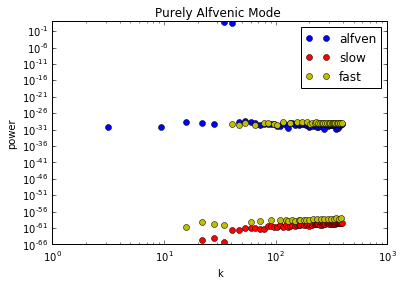

In [7]:
#Test for a linear purely Alfvenic Mode
#can experimenet with changing beta
beta=1.;
#experiment with changing NN - changes peak of power
NN=6.
n=128
xg=np.linspace(0.,1.,n+1,endpoint=False)
yg=np.linspace(0.,1.,n+1,endpoint=False)
zg=np.linspace(0.,1.,n+1,endpoint=False)
x,y,z=np.meshgrid(xg,yg,zg)#,indexing='ij')
Vx = np.zeros((n+1,n+1,n+1))
Vz = np.zeros((n+1,n+1,n+1))#+.01*np.random.rand(n,n,n)

Vy = 10.1*np.sin(2.*NN*np.pi*x)

kgridG,alfVIso,fastVIso,slowVIso=mode_decomp(Vx,Vy,Vz,beta)
#plt.loglog(kgridG,viso,'ko',label='viso')
plt.loglog(kgridG,alfVIso,'bo',label='alfven')
plt.loglog(kgridG,slowVIso,'ro',label='slow')
plt.loglog(kgridG,fastVIso,'yo',label='fast')
plt.legend()
plt.xlabel('k')
plt.ylabel('power')
plt.title('Purely Alfvenic Mode ')

In [6]:
print alfVIso

[  1.04003141e-30   1.27046869e-29   2.07871913e-30   3.37032267e-30
   5.10050000e+01   2.55025000e+01   6.21898433e-30   5.72372717e-29
   6.96091266e-30   1.40414842e-29   1.86552157e-29   1.02068092e-29
   9.77455217e-30   6.94297422e-30   2.66095760e-30   3.32324557e-30
   7.89092932e-31   1.06552439e-30   4.52395346e-30   1.95984479e-30
   1.01818450e-29   6.66760957e-30   9.08096768e-31   2.27603641e-30
   2.73414420e-30   6.74397590e-30   2.55228869e-30   2.84117333e-30
   1.11352598e-30   1.66286287e-30   1.49578548e-30   3.29668305e-30
   6.70408970e-30   3.51611999e-30   2.65270504e-30   5.12548685e-30
   2.46419268e-30   1.48415963e-30   8.07851975e-31   4.16934118e-30
   1.05122217e-30   2.77816490e-30   5.88593713e-30   4.98970665e-30
   2.00929294e-30   2.36820602e-30   2.86195190e-30   1.42959480e-30
   1.94380294e-30   1.67193749e-30   1.33305575e-30   1.65728040e-30
   8.97003741e-31   7.13014497e-31   1.18273180e-30   1.58607922e-30
   1.87495851e-30   1.28056947e-30

hello


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in divide


hey!


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:123: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:124: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:125: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:134: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:135: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:136: RuntimeWarning: invalid value encountered in divide


63
63
63
[  1.02552426e-32   5.19395780e-31   5.10050000e+01   2.55025000e+01
   1.45988992e-29   2.14964706e-29   3.85759427e-29   5.35314916e-31
   1.62409579e-30   3.97249127e-30   1.03240485e-30   1.58056417e-29
   1.86410078e-29   3.53795265e-30   6.06282735e-30   5.01823539e-30
   3.01085103e-31   1.27331777e-29   1.37280594e-29   3.19612776e-30
   7.16831852e-30   5.91369753e-30   2.44522146e-31   1.44521496e-29
   1.43099724e-29   3.66367267e-31   8.36481300e-30   8.29188030e-30
   1.32005077e-31   1.11200499e-29   1.12853618e-29   5.08539278e-31
   1.14901418e-29   9.91014162e-30   1.91304681e-31   1.62112021e-29
   1.68740761e-29   1.46820065e-30   1.30602425e-29   1.13713075e-29
   1.25354248e-31   2.32005615e-29   1.86376670e-29   2.85244187e-31
   1.11065223e-29   1.12432891e-29   2.60109241e-31   1.34111994e-29
   1.33217619e-29   1.45484053e-31   1.23623835e-29   1.26510102e-29
   9.56002906e-31   1.50909795e-29   1.52457263e-29   3.10264168e-31
   1.09296303e-29   1.112

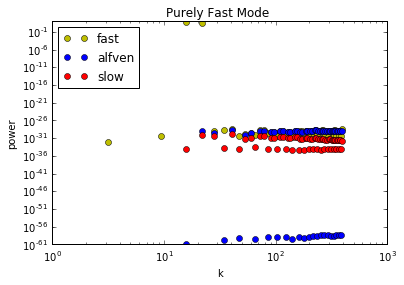

In [8]:
#test just a fast wave 
# Frank Shu Gas Dynamics page 307 example b - k perp to B_0 - then the slow velocity is zero
beta=1.;
#units alfven speed = 1
NN = 3.

xg=np.linspace(0.,1.,n+1,endpoint=False)
yg=np.linspace(0.,1.,n+1,endpoint=False)
zg=np.linspace(0.,1.,n+1,endpoint=False)
x,y,z=np.meshgrid(xg,yg,zg)#,indexing='ij')

xpart=1.#.01
zpart=np.sqrt(1.-xpart**2)
Vy = np.zeros((n+1,n+1,n+1))
Vz =np.zeros((n+1,n+1,n+1))
Vx = 10.1*np.sin(2.*NN*np.pi*(xpart*x+zpart*z))



kgridG,alfVIso,fastVIso,slowVIso=mode_decomp(Vx,Vy,Vz,beta)
plt.loglog(kgridG,fastVIso,'yo',label='fast')
plt.loglog(kgridG,alfVIso,'bo',label='alfven')
plt.loglog(kgridG,slowVIso,'ro',label='slow')

#plt.yscale('log')

plt.legend(loc='upper left')
plt.xlabel('k')
plt.ylabel('power')
plt.title('Purely Fast Mode ')
print fastVIso

hello


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in divide


hey!


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:123: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:124: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:125: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:134: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:135: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:136: RuntimeWarning: invalid value encountered in divide


63
63
63
[  2.49116812e-31   7.21632538e-31   5.00000000e+01   2.50000000e+01
   1.44226240e-29   1.65142261e-29   3.57097437e-29   5.17445892e-31
   3.30917993e-30   4.52930850e-30   1.46292007e-30   1.57235041e-29
   1.96579025e-29   3.04997446e-30   6.28804530e-30   5.52335496e-30
   4.16637426e-31   1.28302884e-29   1.41004676e-29   3.17082657e-30
   7.10143601e-30   5.86043258e-30   4.96343601e-31   1.46472985e-29
   1.45375193e-29   7.12168616e-31   8.59583788e-30   8.20367782e-30
   1.42769980e-31   1.10908783e-29   1.11903922e-29   5.46813902e-31
   1.32216180e-29   1.09989777e-29   1.57521919e-31   1.62287111e-29
   1.67012350e-29   1.61046664e-30   1.15896802e-29   1.05597446e-29
   1.39538773e-31   2.09873798e-29   1.76297877e-29   2.96538335e-31
   1.08223406e-29   1.10057577e-29   1.60705316e-31   1.32622563e-29
   1.33921118e-29   3.48071206e-31   1.18602330e-29   1.20223811e-29
   1.00158941e-30   1.49631355e-29   1.54415367e-29   5.10501732e-31
   1.07250905e-29   1.102

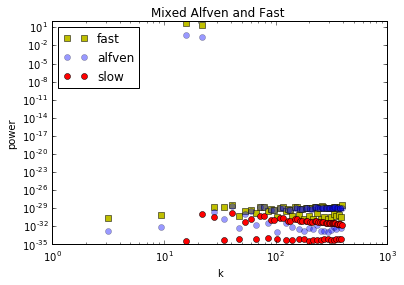

In [9]:
#Mixed Alfven and Fast Test - so we know that the ratios are correct

beta=1.;
#units alfven speed = 1
NN = 3.

np.zeros((n+1,n+1,n+1))
x,y,z=np.meshgrid(xg,yg,zg)#,indexing='ij')

xpart=1.#.01
zpart=np.sqrt(1.-xpart**2)

Vz =np.zeros((n+1,n+1,n+1))
Vy = 1.*np.sin(2.*NN*np.pi*x)
Vx = 10.*np.sin(2.*NN*np.pi*(xpart*x+zpart*z))



kgridG,alfVIso,fastVIso,slowVIso=mode_decomp(Vx,Vy,Vz,beta)
plt.loglog(kgridG,fastVIso,'ys',label='fast')
plt.loglog(kgridG,alfVIso,'bo',label='alfven',alpha=.4)
plt.loglog(kgridG,slowVIso,'ro',label='slow')

#plt.yscale('log')

plt.legend(loc='upper left')
plt.xlabel('k')
plt.ylabel('power')
plt.title('Mixed Alfven and Fast ')
print fastVIso

In [10]:
print fastVIso/alfVIso


[ 130.8734202   100.17777395  100.          100.            5.23853285
   91.6205498     1.67640073   90.79349323    3.17042741    1.38750326
   81.24271709    1.0813337     1.35232185   75.29491364    1.30946586
    1.15674212  323.83749704    1.03051499    1.13600027   99.43788594
    1.15845703    0.96100774   67.51737784    1.09291842    1.08844772
  178.05763244    1.10567441    1.05895466   71.29296484    1.05091975
    1.06346937  109.26287972    1.6397661     1.37210973   47.80272796
    1.04479023    1.07747747  104.5330104     1.23374934    1.1279095
   93.0425197     1.62572026    1.3734601   153.5191194     1.05793549
    1.078288    141.53379702    1.01201947    1.02406385  132.01841876
    1.05523163    1.07118388  112.49288373    1.06092492    1.09663693
  154.35512431    1.04695224    1.07740851   52.67317246    1.08807033
    1.09618968   55.85159452    3.01040903]


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in divide


hey!


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:123: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:124: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:125: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:134: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:135: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:136: RuntimeWarning: invalid value encountered in divide


63
63
63


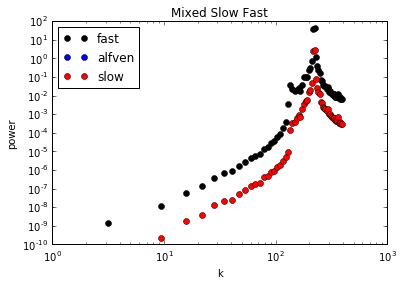

In [6]:
#now test a slow mode and fast mode
beta=1.;
#units alfven speed = 1
NN = 35.

xg=np.linspace(0.,1.,n)
yg=np.linspace(0.,1.,n)
zg=np.linspace(0.,1.,n)
x,y,z=np.meshgrid(xg,yg,zg)#,indexing='ij')

xpart=.6#.01
zpart=np.sqrt(1.-xpart**2)
Vy = np.zeros((n,n,n))
Vz =np.zeros((n,n,n))
Vx = 10.1*np.sin(2.*NN*np.pi*(xpart*x+zpart*z))


kgridG,alfVIso,fastVIso,slowVIso=mode_decomp(Vx,Vy,Vz,beta)
plt.loglog(kgridG,fastVIso,'ko',label='fast')
plt.loglog(kgridG,alfVIso,'bo',label='alfven')
plt.loglog(kgridG,slowVIso,'ro',label='slow')

#plt.yscale('log')

plt.legend(loc='upper left')
plt.xlabel('k')
plt.ylabel('power')
plt.title('Mixed Slow Fast')

2.05817102727
0.485868271757
hello


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in divide


hey!


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:123: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:124: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:125: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:134: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:135: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:136: RuntimeWarning: invalid value encountered in divide


63
63
63
[ 13.8160958    4.03696513  10.18968672   6.39137515   5.42251083
   5.25652632   4.84347238   4.72371504   4.58650481   4.48507502
   4.46092082   4.4052008    4.41043743   4.35422434   4.34698866
   4.31629873   4.30174566   4.30020378   4.3070717    4.28778762
   4.28125514   4.26946686   4.26494115   4.2583907    4.26652296
   4.25229571   4.2548152    4.24821206   4.24516579   4.24873755
   4.24544529   4.24546833   4.24210887   4.24029759   4.23826163
   4.23482889   4.25015752   4.25274495   4.23655679   4.23440185
   4.23268723   4.23393562   4.23229818   4.23401029   4.23182323
   4.23024248   4.22889316   4.22897554   4.23010655   4.22780517
   4.23151935   4.22873252   4.22719757   4.22808503   4.226575
   4.22839683   4.22786302   4.22649392   4.24294987   4.22440665
   4.22818288   4.22608233   4.22635065]


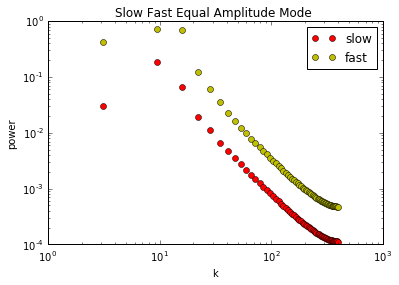

In [12]:
#new test - just set theta, solve for ratios
beta=1.;
NN=2.
n=128

xg=np.linspace(0.,1.,n+1,endpoint=False)
yg=np.linspace(0.,1.,n+1,endpoint=False)
zg=np.linspace(0.,1.,n+1,endpoint=False)
x,y,z=np.meshgrid(xg,yg,zg)

theta = np.pi/4.


k = 2.*np.pi*NN
kx = 2.*np.pi*NN*np.sin(theta)
kz = 2.*np.pi*NN*np.cos(theta)


alpha= beta/2.
D=((1.+alpha)**2-4.*alpha*np.cos(theta)*np.cos(theta))
xzratio_fast = ((1.+alpha+np.sqrt(D))/(-1.+alpha+np.sqrt(D)))**(.5)
print xzratio_fast

xzratio_slow = (abs((1.+alpha-np.sqrt(D))/(-1.+alpha-np.sqrt(D))))**(.5)

print xzratio_slow

#fast wave
Vz = np.sin(kx*x+kz*z)
Vx = xzratio_fast*np.sin(kx*x+kz*z)

#slow wave
#Vz += np.sin(kx*x+kz*z)
#Vx+= xzratio_slow*np.sin(kx*x+kz*z)
Vy = np.zeros((n+1,n+1,n+1))
kgridG,alfVIso,fastVIso,slowVIso=mode_decomp(Vx,Vy,Vz,beta)

print fastVIso/slowVIso
 

plt.loglog(kgridG,slowVIso,'ro',label='slow')
plt.loglog(kgridG,fastVIso,'yo',label='fast')
plt.legend()
plt.xlabel('k')
plt.ylabel('power')
plt.title('Slow Fast Equal Amplitude Mode ')
plt.savefig('slowfast_equal.pdf')

0.541196100146
1.30656296488
2.41421356237
fast ratio
-2.41421356237
slow ratio
0.414213562373
hello


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in divide


hey!


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:123: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:124: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:125: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:134: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:135: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:136: RuntimeWarning: invalid value encountered in divide


63
63
63
[ 2.53570682  9.40270548  3.05940744  2.37935108  2.05273818  1.99500198
  2.2558289   2.40475301  2.58897616  3.11594209  3.19095103  3.4143029
  3.43355339  3.83790469  3.98444976  4.14012759  4.45232786  4.36716691
  4.46666641  4.56902711  4.64269101  4.75390381  4.83287749  4.9010565
  4.95442948  5.03287684  5.07631509  5.12609189  5.17343267  5.21306912
  5.24394583  5.288949    5.32114405  5.35555846  5.38484132  5.41255231
  5.44551332  5.46364975  5.4821521   5.50349226  5.52183535  5.54032237
  5.55550242  5.57452441  5.58993363  5.60557541  5.61915283  5.63187012
  5.64421823  5.65754815  5.66568698  5.67755878  5.68756913  5.69734044
  5.706632    5.71532933  5.7223179   5.73183     5.74366854  5.74724539
  5.75378166  5.76097739  5.7677982 ]


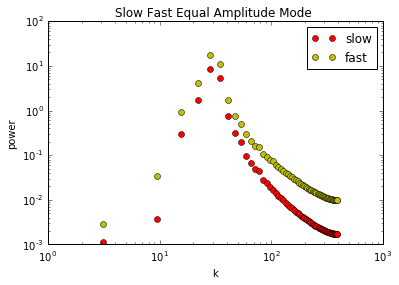

In [14]:
# new mixed slow fast mode test based on Jono's notes
beta=1.;
NN=5.
n=128
xg=np.linspace(0.,1.,n+1,endpoint=False)
yg=np.linspace(0.,1.,n+1,endpoint=False)
zg=np.linspace(0.,1.,n+1,endpoint=False)
x,y,z=np.meshgrid(xg,yg,zg)

theta = np.pi/4.

k = 2.*np.pi*NN
kx = 2.*np.pi*NN*np.sin(theta)
kz = 2.*np.pi*NN*np.cos(theta)

#1/beta
b0= 1./beta
vs = np.sqrt(.5*(1.+b0**2-((1.+b0**2)**2-4.*b0**2*kz**2/k**2)**.5))
vf = np.sqrt(.5*(1.+b0**2+((1.+b0**2)**2-4.*b0**2*kz**2/k**2)**.5))
print vs
print vf
print vf/vs
#fast wave
Vx = -.01*kx*k*vf*np.sin(kx*x+kz*z)
Vz = -.01*vf*k/kz*(-kz**2+k**2*vs**2)*np.sin(kx*x+kz*z)

#slow wave
#Vx += -.01*kx*k*vs*np.sin(kx*x+kz*z)
#Vz += -.01*vs*k/kz*(-kz**2+k**2*vf**2)*np.sin(kx*x+kz*z)

print "fast ratio"
print (-kx*k*vf)/(-vf*k/kz*(-kz**2+k**2*vs**2))
print "slow ratio"
print (-kx*k*vs)/(-vs*k/kz*(-kz**2+k**2*vf**2))

Vy = np.zeros((n+1,n+1,n+1))

kgridG,alfVIso,fastVIso,slowVIso=mode_decomp(Vx,Vy,Vz,beta)

print fastVIso/slowVIso
 

plt.loglog(kgridG,slowVIso,'ro',label='slow')
plt.loglog(kgridG,fastVIso,'yo',label='fast')
plt.legend()
plt.xlabel('k')
plt.ylabel('power')
plt.title('Slow Fast Equal Amplitude Mode ')
plt.savefig('slowfast_equal.pdf')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in divide


hey!


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:122: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:123: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:124: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:133: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:134: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:135: RuntimeWarning: invalid value encountered in divide


63
63
63
[ 0.28776075  0.41060495  0.4686604   0.56574262  0.71428965  0.75246224
  0.70850728  0.65763787  0.59838148  0.52508213  0.4929087   0.46232621
  0.44537745  0.42189223  0.40637416  0.3930373   0.3820221   0.37210231
  0.36469688  0.35647012  0.34998842  0.3448035   0.33947938  0.33513384
  0.33172106  0.32834094  0.3246447   0.32176272  0.31925993  0.31705169
  0.31485784  0.31301693  0.31127531  0.30956314  0.30810175  0.30665667
  0.31266604  0.31171604  0.30322266  0.30217944  0.30125676  0.3004017
  0.29951671  0.29877256  0.29803078  0.29733006  0.2967088   0.29610396
  0.29553888  0.29501784  0.29453637  0.29401177  0.29353801  0.29311322
  0.2926921   0.29231269  0.29191901  0.2915696   0.29121305  0.29088448
  0.29057747  0.29025691  0.28996174]



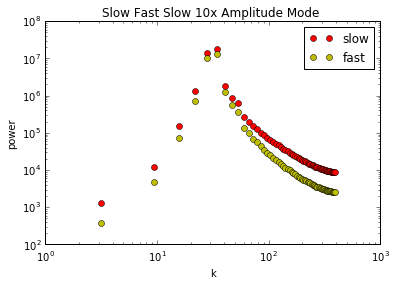

In [145]:
#same thing as above but changing amplitude in the modes

#fast wave
Vx = -kx*k*vf*np.sin(kx*x+kz*z)
Vz = -vf*k/kz*(-kz**2+k**2*vs**2)*np.sin(kx*x+kz*z)

#slow wave
Vx += -10.*kx*k*vs*np.sin(kx*x+kz*z)
Vz += -10.*vs*k/kz*(-kz**2+k**2*vf**2)*np.sin(kx*x+kz*z)

Vy = np.zeros((n,n,n))

kgridG,alfVIso,fastVIso,slowVIso=mode_decomp(Vx,Vy,Vz,beta)

print fastVIso/slowVIso
print 

plt.loglog(kgridG,slowVIso,'ro',label='slow')
plt.loglog(kgridG,fastVIso,'yo',label='fast')
plt.legend()
plt.xlabel('k')
plt.ylabel('power')
plt.title('Slow Fast Slow 10x Amplitude Mode ')
plt.savefig('slowfast_10x.pdf')

In [146]:
#now run the code on our simulation
infi=h5py.File('/Users/darrylseligman/Desktop/Flatiron/Phil/Initial_Magnetic_Simulations/jono_default_params/b0_N64/output_wheeler/dust_ALFVEN_snap_0946.h5','r') # (defined same as above) 
print("Keys: %s" % infi.keys())
#h_g = np.array(infi["Smoothing_Length_List_Of_Gas_Neighbors"]) # this will act like a normal vector: h_g[:] for all elements
#h_d=np.array(infi["Smoothing_Length_List_Of_Dust_Neighbors"])
#read the list of B and V
#B0=np.array(infi["Mass_Density_List_Of_Gas_Neighbors_B0"])
#B1=np.array(infi["Mass_Density_List_Of_Gas_Neighbors_B1"])
#B2=np.array(infi["Mass_Density_List_Of_Gas_Neighbors_B2"])

V0=np.array(infi["Mass_Density_List_Of_Gas_NeighborsVX"])
V1=np.array(infi["Mass_Density_List_Of_Gas_NeighborsVY"])
V2=np.array(infi["Mass_Density_List_Of_Gas_NeighborsVZ"])
xgrid=np.array(infi["x_grid"])
#nngb_d_v1=np.array(infi["Mass_Density_List_Of_Dust_Neighbors_v1"])
#nngb_g_v1=np.array(infi["Mass_Density_List_Of_Gas_Neighbors_v1"])

infi.close() 

kgridG,alfVIso,fastVIso,slowVIso=mode_decomp(V0,V1,V2,1.)


Keys: [u'Desired_Number_Of_Neighbors', u'Mass_Density_List_Of_Gas_NeighborsVX', u'Mass_Density_List_Of_Gas_NeighborsVY', u'Mass_Density_List_Of_Gas_NeighborsVZ', u'Minimum_Smoothing_Length_Allowed', u'Number_Of_Simulation_Dimensions', u'Periodic_BoxSize', u'Smoothing_Length_List_Of_Gas_NeighborsVX', u'Smoothing_Length_List_Of_Gas_NeighborsVY', u'Smoothing_Length_List_Of_Gas_NeighborsVZ', u'Snapshot_Directory', u'Snapshot_Number', u'Snapshot_Time', u'Total_Number_Of_Dust_Particles', u'Total_Number_Of_Gas_Particles', u'x_grid', u'y_grid', u'z_grid']
hello


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:46: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:47: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in divide


hey!


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:122: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:123: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:124: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:133: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:134: RuntimeWarning: invalid value encountered in divide
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:135: RuntimeWarning: invalid value encountered in divide


62
62
62


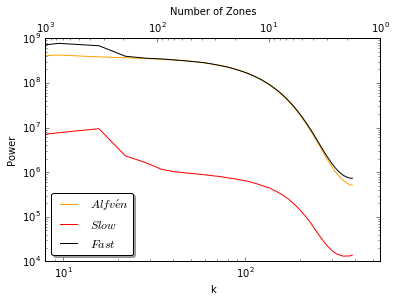

In [147]:
fig, ax1 = plt.subplots()
#kvec=(np.arange(len(kgridG))+1)*2.*np.pi
#kvec2=np.arange(512+5)#*2.*np.pi
#print kvec2

ax1.loglog(kgridG,alfVIso,label=r'$Alfv\'en$',color='orange',alpha=1.)
ax1.loglog(kgridG,slowVIso,'r',label=r'$Slow$')
ax1.loglog(kgridG,fastVIso,'k',label=r'$Fast$')

ax1.set_xlim([8.,550])
ax2=ax1.twiny()
ax2.loglog(kgridG/(np.pi),np.zeros_like(kgridG))
ax2.set_xlim(ax2.get_xlim()[::-1])
#ax2.set_xlim(512.,1.)
#print ax2.get_xlim()[::-1]
ax2.set_xlabel('Number of Zones',fontsize=10)
ax1.set_xlabel('k',fontsize=10)
ax1.set_ylabel('Power',fontsize=10)
#ax1.set_ylim([5.e3,1.e9])
ax1.legend(fancybox=True, shadow=True,loc='lower left')
plt.savefig('Saturated_64x64x64_decomposition.pdf')
#plt.ylabel('Power')

In [110]:
print fastVIso

[  7.11184257e+11   5.99244491e+08   5.46132710e+08   3.91861612e+08
   3.56217772e+08   3.41776665e+08   3.26603600e+08   3.12552794e+08
   2.97269078e+08   2.81946777e+08   2.64599547e+08   2.47132231e+08
   2.30446042e+08   2.12613752e+08   1.94887101e+08   1.78555527e+08
   1.62270310e+08   1.46571851e+08   1.52335131e+08   1.18016188e+08
   1.04947138e+08   9.29245946e+07   8.15561112e+07   7.15746524e+07
   6.24247101e+07   5.41156951e+07   4.66548806e+07   4.00328659e+07
   3.42826936e+07   2.91881554e+07   2.47371531e+07   2.09565848e+07
   1.76719599e+07   1.48230642e+07   1.24580028e+07   1.04156508e+07
   9.86848969e+06   8.41806320e+06   6.15446839e+06   5.16908081e+06
   4.37862812e+06   3.71094500e+06   3.14826558e+06   2.69867931e+06
   2.33162550e+06   2.02743204e+06   1.78462727e+06   1.57606186e+06
   1.40985306e+06   1.27527560e+06   1.16694587e+06   1.07696949e+06
   1.00026102e+06   9.40087622e+05   8.90736884e+05   8.49928618e+05
   8.23049650e+05   7.95633211e+05